In [6]:
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from data import FocusDataset

import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [7]:
train_data_list = ['00_01', '00_02', '00_05', '10_02', '10_03']
valid_data_list = ['00_01', '00_02']

In [8]:
base_path = '/shared_data/focussu/109.학습태도_및_성향_관찰_데이터/3.개방데이터/1.데이터'
train_dataset = FocusDataset(base_path+'/Training', train_data_list)
test_dataset = FocusDataset(base_path+'/Validation', valid_data_list)
print(len(train_dataset))


pkl_files: 214669
meta_files: 214669
메타데이터 로딩 중...


메타데이터: 100%|██████████| 214669/214669 [00:44<00:00, 4785.53it/s]


pkl_files: 1717
meta_files: 1717
메타데이터 로딩 중...


메타데이터: 100%|██████████| 1717/1717 [00:00<00:00, 5094.50it/s]

214669


## Model (XGBoost with Blendshape)

In [9]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [10]:
X_list, y_list = [], []
for sample in tqdm(train_dataset, desc="훈련 데이터 수집"):
    blendshape = sample['blendshapes'].view(-1).numpy()  # (52,)
    label = sample['label']['category_id']               # int
    X_list.append(blendshape)
    y_list.append(label)

X = np.stack(X_list)
y = np.array(y_list)

le = LabelEncoder()
y = le.fit_transform(y)  # y_encoded는 0부터 시작하는 연속된 정수

X_list = []
y_list = []

for sample in tqdm(test_dataset, desc="테스트 데이터 수집"):
    blendshape = sample['blendshapes'].view(-1).numpy()  # (52,)
    label = sample['label']['category_id']               # int
    X_list.append(blendshape)
    y_list.append(label)

X_test = np.stack(X_list)
y_test = np.array(y_list)
y_test = le.transform(y_test)


테스트 데이터 수집: 100%|██████████| 1717/1717 [00:00<00:00, 2358.75it/s]


In [11]:
print("전체 클래스 분포:", np.bincount(y))         # 훈련
print("테스트 클래스 분포:", np.bincount(y_test))  # 테스트 데이터

전체 클래스 분포: [117594  90996   6079]
테스트 클래스 분포: [1717]


In [12]:

model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=len(np.unique(y)),
    max_depth=4,
    learning_rate=0.1,
    n_estimators=100,
    use_label_encoder=False,
    eval_metric='mlogloss'
)

model.fit(X, y)

/home/hyun/anaconda3/envs/focussu-ai/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:21:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_class=3, num_parallel_tree=None, ...)


🔍 Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1717
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0

    accuracy                           0.99      1717
   macro avg       0.33      0.33      0.33      1717
weighted avg       1.00      0.99      0.99      1717



/home/hyun/anaconda3/envs/focussu-ai/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hyun/anaconda3/envs/focussu-ai/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hyun/anaconda3/envs/focussu-ai/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

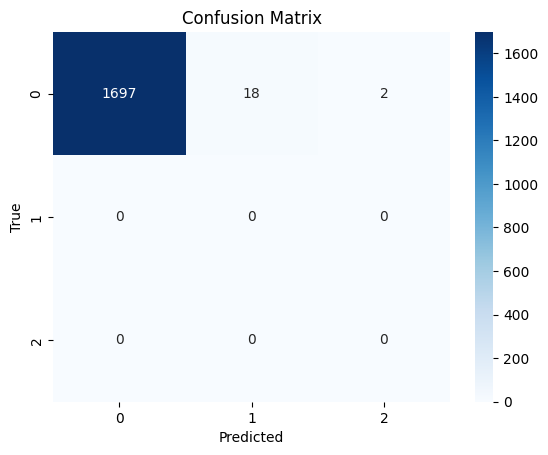

In [13]:
# 예측
y_pred = model.predict(X_test)

# 예측값이 one-hot 또는 확률벡터일 경우 정수 인덱스로 변환
if y_pred.ndim > 1:
    y_pred = np.argmax(y_pred, axis=1)

# classification_report 출력
print("\n🔍 Classification Report:\n")
print(classification_report(y_test, y_pred))

# confusion matrix 시각화
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [14]:
print("전체 클래스 분포:", np.bincount(y))         # 전체 데이터
print("훈련 클래스 분포:", np.bincount(y_train))   # 훈련 데이터
print("테스트 클래스 분포:", np.bincount(y_test))  # 테스트 데이터


전체 클래스 분포: [117594  90996   6079]


NameError: name 'y_train' is not defined

## DL Model

In [4]:
loader = DataLoader(dataset, num_workers=1, batch_size=10, shuffle=True)